In [3]:
from simple21env import *
import numpy as np

In [31]:
# Environment code is under simple21env.py

In [4]:
env = simple21env()
print(env.reset())
print(env.step(0))
print(env.step(1))
print(env.reset())

(2, 9, 0, False)
(-6, 9, -1, True)
Episode is over, reset environment
None
(1, 1, 0, False)


# 1. GLIE Monte Carlo Control pseudo algorithm  

Initialize for all states and actions:  

Q(s,a), policy(s), Rewards(s,a) <- empty list  

Repeat:  

    1.Generate episode using e-greedy on policy(s)  
    2.For each state-action pair :  
        2.1 R <- return following the first occurance of s,a  
        2.2 Append R to Returns(s,a)  
        2.3 update Q(s,a) <-- average ( Returns(s,a) )  
    3.For each s in the episode:  
        update policy(s) <-- argmax(Q(s,a))
        
        
Notes. On exercise it states to use:  
1. a time-varying scalar step-size of αt = 1/N(st, at)  
2. an e-greedy exploration strategy with et = N0/(N0 + N(st)), where N0 = 100 is a constant, N(s) is the number of times that state s has been visited, and N(s, a) is the number of times that action a has been selected from state s. 

So we have to also keep track:  
N(s) <-- number of times each state has been visited  
N(s,a) <-- number of times each action on a state has been chosen  


### Approach

I consider that the states that we are interested in are :  
Agents hand [12-21] and Dealers hand [1-10]. We are not interested in the initial states for the agent, when the agents hand is between [1-11] since the only transition is to fetch a new card always. I therefore create an initial extra state. We therefore have 100 + 1 desired states. 

In [5]:
def initialize_monte_calro_simple21():
    """
    Initialize Q table, policy table, N table for e-greedy exploration 
    and Na for adaptive step size during policy updates.
    Also, a mapping dicitionary that maps combination of hands to indexes of states.
    The state with index 100 is every combination of hands where agents_hand < 12.
    """
    Q = np.zeros((101,2))
    policy = np.zeros((101),dtype=int)
    N = np.zeros((101))
    Na = np.zeros((101,2))
    mapping = {}
    k = 0
    for i in range(0,22):
        for j in range(1,11):
            if i <12:
                mapping[str(i)+','+str(j)] = 100
            else:
                mapping[str(i)+','+str(j)] = k
                k+=1
    return Q,policy,N,Na,mapping

def run_mc_episode(env,policy):
    """
    Monte carlo simulation for a single episode:
    Initialize the environment to a desired state, act e-greedily and store all actions-rewards for the episode.
    """
    N0 = 100
    agent_hands = []
    dealers_hands = []
    actions = []
    episode_rewards = []
    epsilon_tracker = []
    
    agent_hand,_,_,_ = env.reset()
    while agent_hand<12:
        agent_hand,dealers_hand,_,done = env.step(0)
        if done:
            agent_hand,_,_,_ = env.reset()
    
    agent_hands.append(agent_hand),dealers_hands.append(dealers_hand),episode_rewards.append(0)
    
    while not done:  
        
        e = N0 / (N0 + N[mapping[str(agent_hand)+","+str(dealers_hand)]])
        if random.random() > e:
            action = policy[mapping[str(agent_hand)+","+str(dealers_hand)]]
        else:
            action = random.randint(0,1)
        epsilon_tracker.append(e)
        
        agent_hand,dealers_hand,reward,done = env.step(action)
        
        agent_hands.append(agent_hand),dealers_hands.append(dealers_hand),actions.append(action),episode_rewards.append(reward)

    
    return agent_hands,dealers_hands,actions,episode_rewards,np.mean(np.array(epsilon_tracker))

In [6]:
def update_mc_counts(agent_hands,dealers_hands,actions):
    
    for a_h,d_h,action in zip(agent_hands[:-1],dealers_hands[:-1],actions):
        
        N[mapping[str(a_h)+","+str(d_h)]]+=1
        Na[mapping[str(a_h)+","+str(d_h)],action]+=1

def policy_evaluation(agent_hands,dealers_hands,actions,episode_rewards):
    
    R = episode_rewards[-1]
    for a_h,d_h,action in zip(agent_hands[:-1],dealers_hands[:-1],actions):
        a = 1 / Na[mapping[str(a_h)+","+str(d_h)],action]
        Q[mapping[str(a_h)+","+str(d_h)],action] = Q[mapping[str(a_h)+","+str(d_h)],action] + a* (R-Q[mapping[str(a_h)+","+str(d_h)],action])
        
        

        
def policy_update(policy,agent_hands,dealers_hands):
    
    for a_h,d_h in zip(agent_hands[:-1],dealers_hands[:-1]):
        policy[mapping[str(a_h)+","+str(d_h)]] = np.argmax(Q[mapping[str(a_h)+","+str(d_h)]])

In [7]:
import matplotlib

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.ioff()

def plot_blackjack_values(V,i):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        y_range = np.arange(12, 22)
        x_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = V.reshape(X.shape) #np.array([ for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(Y, X, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum',fontsize=14)
        ax.set_ylabel('Dealer\'s Showing Card',fontsize=14)
        ax.set_zlabel('State Value',fontsize=14)
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))

    ax = fig.add_subplot(111, projection='3d')
    ax.set_title('Final State Value function')
    get_figure(False, ax)

    plt.show()
    #plt.savefig("simple21_monte_carlo_Value/"+str(i)+'.png')
    #plt.close(fig)

# plot the state-value function
#plot_blackjack_values(to_visualize[:-1],i)    

In [17]:
%matplotlib inline

max_episodes = 50000
print_every = 1000
running_rewards = []
epsilons = []
epsilons_to_plot = []
rewards_to_plot = []
env = simple21env()
Q,p,N,Na,mapping = initialize_monte_calro_simple21()

for episode in range(1,max_episodes+1):
    agent_hands,dealers_hands,actions,episode_rewards,episode_epsilon = run_mc_episode(env,p)
    epsilons.append(episode_epsilon)
    running_rewards.append(episode_rewards[-1])
    update_mc_counts(agent_hands,dealers_hands,actions)
    policy_evaluation(agent_hands,dealers_hands,actions,episode_rewards)
    policy_update(p,agent_hands,dealers_hands)
    
    if episode % print_every == 0 :
        print("Running average reward: "+str(np.mean(running_rewards[-print_every:]))+" and epsilons: "+str(np.mean(epsilons[-print_every:])))
        #to_visualize = Q.max(1)
        #plot_blackjack_values(to_visualize[:-1],episode)
        epsilons_to_plot.append(np.mean(epsilons[-print_every:]))
        rewards_to_plot.append(np.mean(running_rewards[-print_every:]))

        #print_every+=1000



Running average reward: -0.286 and epsilons: 0.9113763798561367
Running average reward: -0.239 and epsilons: 0.7816799059683498
Running average reward: -0.287 and epsilons: 0.6989034623166029
Running average reward: -0.317 and epsilons: 0.6352502392569828
Running average reward: -0.214 and epsilons: 0.5725582300867433
Running average reward: -0.225 and epsilons: 0.5381456861896008
Running average reward: -0.216 and epsilons: 0.4967887124792635
Running average reward: -0.218 and epsilons: 0.4663881719544726
Running average reward: -0.186 and epsilons: 0.44010050442074716
Running average reward: -0.215 and epsilons: 0.41092511523183745
Running average reward: -0.194 and epsilons: 0.3933691935995823
Running average reward: -0.219 and epsilons: 0.3758924235539456
Running average reward: -0.244 and epsilons: 0.3560885479953771
Running average reward: -0.182 and epsilons: 0.33658806766012456
Running average reward: -0.188 and epsilons: 0.3334784344797679
Running average reward: -0.213 and ep

#### Plotting epsilon decay and average reward over time

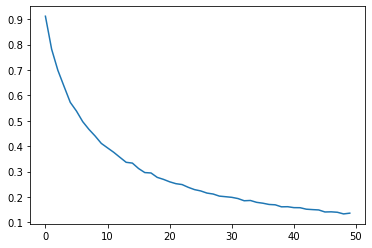

In [20]:
plt.plot(epsilons_to_plot)

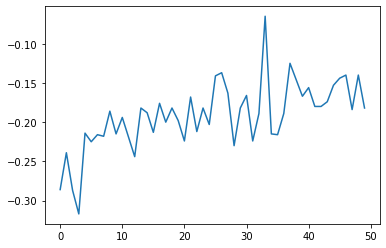

In [21]:
plt.plot(rewards_to_plot)

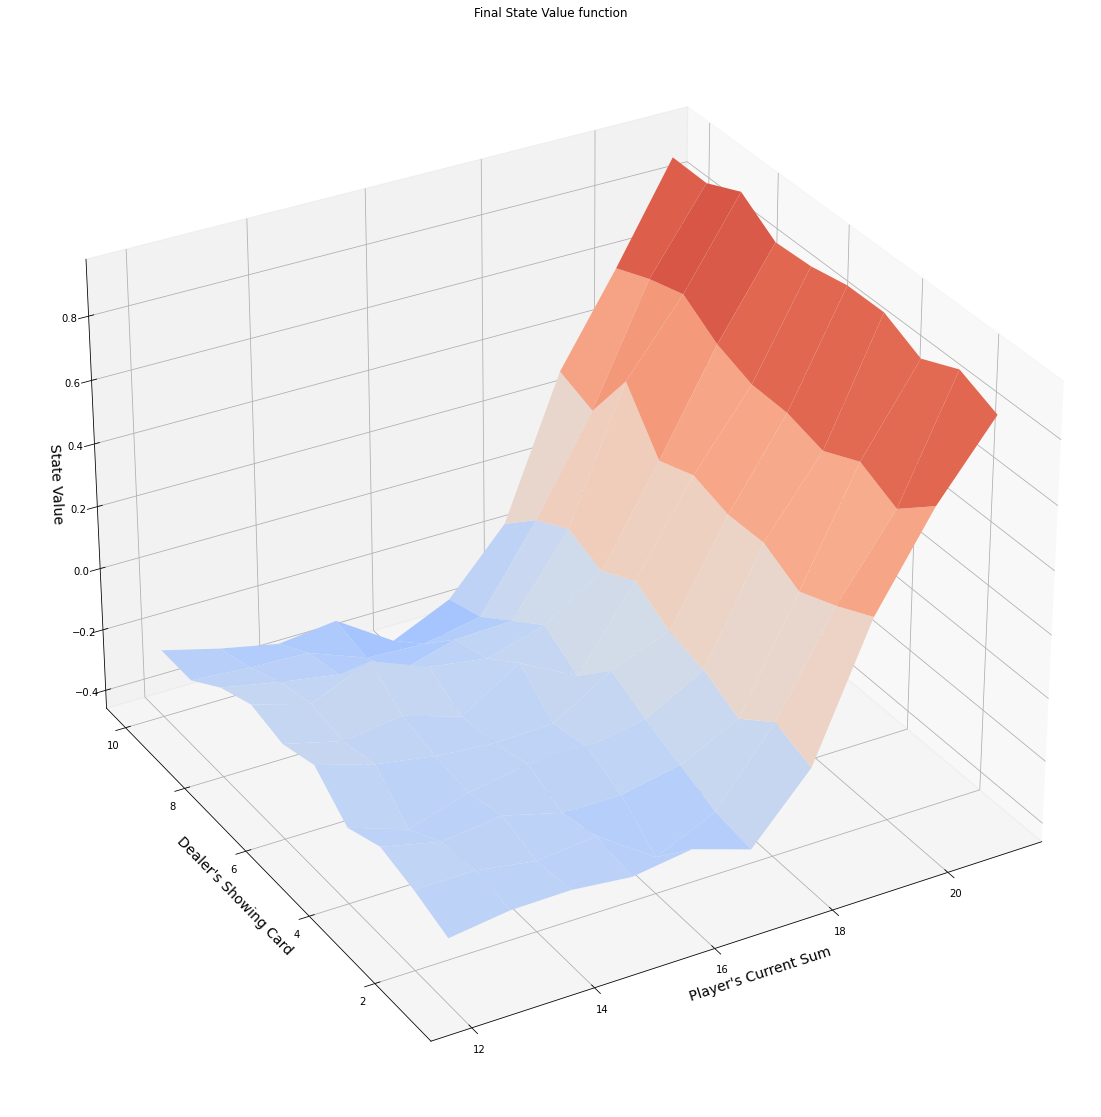

In [22]:
to_visualize = Q.max(1)
plot_blackjack_values(to_visualize[:-1],episode)

In [23]:
# Keep monte carlo Q action-state values for comparison with the next approaches 
MCq = Q[:-1]

# 2. Backward View Sarsa(λ) algorithm  

Initialize Q action value table  
Repeat ( for episode ):   
>    Set E(s,a) eligibility trace table to 0  
>    Reset environmtent  
>   Repeat ( for each step of the episode until episode done ):  
>>        1.Take action A, observe R,S'  
>>        2.Select A' from S' based on e-greedy policy  
>>        3.Calculate TD error d = R + gQ(S',A') - Q(S,A)  
>>        4.Increment current eligibility trace
>>        5.For all states and actions:  
>>>            5.1-Update Q = Q + a*d*E  
>>>            5.2-Update eligibility traces E = g*l*E
>>        6. S = S', A = A'
        

### Approach

Even if it can be done in a simpler way, I stick to the same approach for initializing Q,policy,N,Na tables as in monte carlo simulation. In Sarsa, E table is added that keeps track of the eligibility traces for each episode.

In [25]:
def initialize_sarsa(): 
    Q = np.zeros((101,2))
    policy = np.zeros((101),dtype=int)
    E = np.zeros((101,2),dtype=int)
    N = np.zeros((101))
    Na = np.zeros((101,2))
    mapping = {}
    k = 0
    for i in range(1,22):
        for j in range(1,11):
            if i <12:
                mapping[str(i)+','+str(j)] = 100
            else:
                mapping[str(i)+','+str(j)] = k
                k+=1
    return Q,policy,N,Na,E,mapping

In [26]:
def start_episode(env):
    
    agent_hand,_,_,_ = env.reset()
    while agent_hand<12:
        agent_hand,dealers_hand,_,done = env.step(0)
        if done:
            agent_hand,_,_,_ = env.reset()
    
    return agent_hand,dealers_hand,done

def act_e_greedily(policy,state):
    
    e = N0 / (N0 + N[state]) if N[state] != 0 else 0
    if random.random() > e:
        action = policy[state]
    else:
        action = random.randint(0,1)
    
    return action

def reset_eligibility_traces():
    E = np.zeros((101,2),dtype=int)
    return E

def update_sarsa_counts(state,action):
    N[state]+=1
    Na[state,action]+=1

def online_policy_improvement(d,Q,g = 1):
    for s in range(Q.shape[0]):
        for act in range(Q.shape[1]):
            a = 1 / Na[s,act] if Na[s,act] != 0 else 1
            Q[s,act] += a*d*E[s,act]
            E[s,act] = g*lamda*E[s,act]
        policy[s] = np.argmax(Q[s])
    return Q

In [27]:
def run_episode(env,Q,policy,E,g=1):
    """
    Running episode a single episode for Sarsa(l)
    Initializing the environment, acting e-greedily, updating N,Na and E tables. 
    After every action, the TD-error (delta) is calculated and the Q table is adjusted accordingly.
    """
    agent_hand,dealers_hand,done = start_episode(env)
    
    state = mapping[str(agent_hand)+","+str(dealers_hand)]
    
    action = act_e_greedily(policy,state)
    update_sarsa_counts(state,action)
    while not done:
        
        agent_hand,dealers_hand,reward,done = env.step(action)
        if done:
            delta = reward  - Q[state,action]
            E[state,action]+=1
            Q = online_policy_improvement(delta,Q)
        else:

            next_state = mapping[str(agent_hand)+","+str(dealers_hand)]

            next_action = act_e_greedily(policy,next_state)

            update_sarsa_counts(next_state,next_action)

            delta = reward + g* Q[next_state,next_action] - Q[state,action]
            E[state,action]+=1
            Q = online_policy_improvement(delta,Q)

            action = next_action
            state = next_state
        
    return reward

Running average reward: -0.24 ms_error: 0.11155882921056913
Running average reward: -0.27 ms_error: 0.10971211943967965
Running average reward: -0.29 ms_error: 0.12838120598911826
Running average reward: -0.4 ms_error: 0.07851944649652348
Running average reward: -0.35 ms_error: 0.11086911022003865
Running average reward: -0.28 ms_error: 0.10827429766556655
Running average reward: -0.32 ms_error: 0.09013827143452816
Running average reward: -0.19 ms_error: 0.10976245179540901
Running average reward: -0.12 ms_error: 0.1187771525442744
Running average reward: -0.07 ms_error: 0.12149747617389735
Running average reward: -0.17 ms_error: 0.13969129191233634


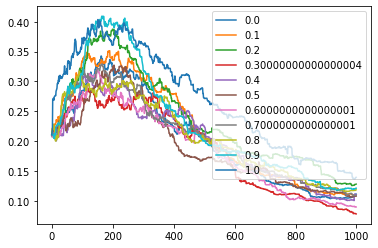

In [28]:
# running sarsa(lamda) for all lamdas in 1000 episodes. Keeping track of MSE error compared to Monte Carlo

max_episodes = 1000
print_every = 100
running_rewards = []
ms_errors = []
ms_episode_errors = []
env = simple21env()
N0 = 100
lamdas = np.arange(0.0,1.1,0.1)
fig, ax = plt.subplots()

for lamda in lamdas:
    Q,policy,N,Na,E,mapping = initialize_sarsa()
    ms_episode_errors = []

    for episode in range(max_episodes):
        E = reset_eligibility_traces()
        running_rewards.append(run_episode(env,Q,policy,E))
        ms_episode_errors.append((np.square(Q[:-1] - MCq)).mean(axis=None))

        #if episode % print_every == 0 :
        #    print("Running average reward: "+str(np.mean(running_rewards[-print_every:])))
    
    ax.plot(ms_episode_errors,label=lamda)
    ax.legend()
        
    ms_errors.append((np.square(Q[:-1] - MCq)).mean(axis=None))
    print("Running average reward: "+str(np.mean(running_rewards[-print_every:]))+" ms_error: "+str((np.square(Q[:-1] - MCq)).mean(axis=None)))

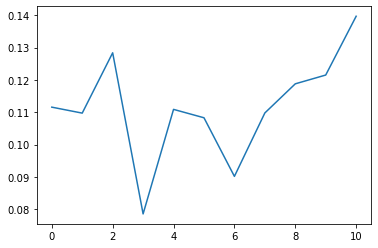

In [29]:
plt.plot(ms_errors)

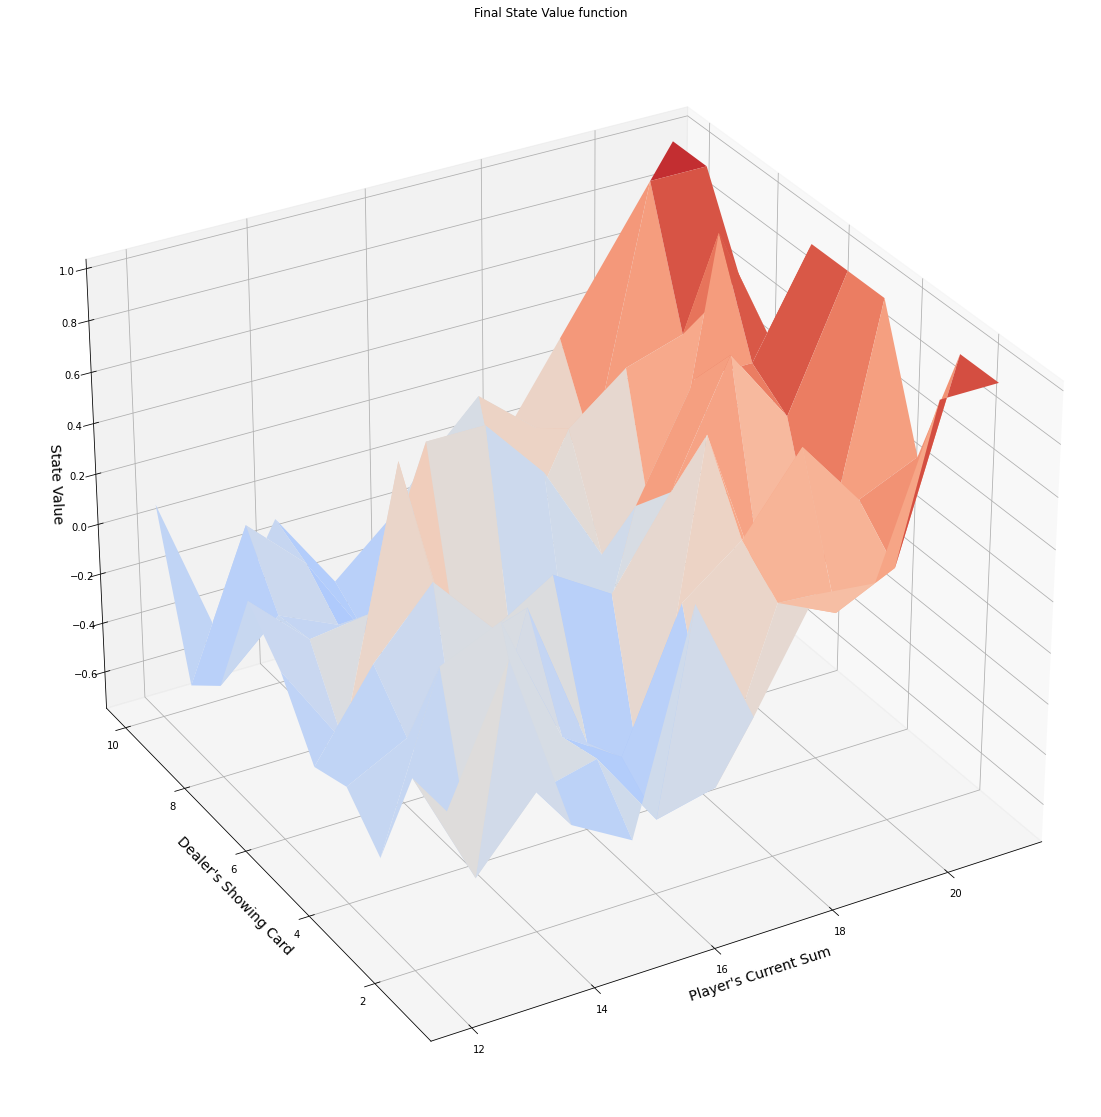

In [30]:
# For lamda = 1
%matplotlib inline

to_visualize = Q.max(1)
plot_blackjack_values(to_visualize[:-1],5)

# 3. Action Value Approximation with coarse coding

In this section coarse coding is going to be used to approximate the Action value function ( Q table ).
The same algorithm stands as before, but instead of having a table for all possible states and actions, which is inneficient, we can approximate the table ( and thus, the policy table also ) with coarse coding.   
In essence, we are reducing the space for the Q table without losing important information.

With coarse coding, each action state value will be calculated by using a feature map, a binary encoding of that state. In this example, the desired state space is 36 ( from 101 as seen previously ).  
The Q table (that previously was 101 * 2 ) will be now a single vector of size 36* 1 and the action-value will be retrieved by multiplying this vector with the binary feature encoding.


In [34]:
def features(agent_hand, dealers_hand, action):
    """
        Binary feature encoding function
        As seen in https://github.com/timbmg/easy21-rl/blob/master/lfa.py
    """ 

    f = np.zeros(3*6*2)

    for fi, (lower, upper) in enumerate(zip(range(1,8,3), range(4, 11, 3))):
        f[fi] = (lower <= dealers_hand <= upper)

    for fi, (lower, upper) in enumerate(zip(range(1,17,3), range(6, 22, 3)), start=3):
        f[fi] = (lower <= agent_hand <= upper)

    f[-2] = 1 if action == 0 else 0
    f[-1] = 1 if action == 1 else 0

    return f.reshape(1, -1)

def Q(agent_hand,dealers_hand,action):
    
    return np.dot(features(agent_hand,dealers_hand,action),theta)

def Q_table():
    """
    Innefficiently compute the entire Q table to calculate MSE with Monte carlo.
    """
    Q_t = np.zeros((10,10,2))
    for i in range(1,11):
        for j in range(12,22):
            for a in range(2):
                Q_t[i-1,j-12,a] = Q(j,i,a)
    return Q_t

In [35]:
def start_episode(env):
    
    agent_hand,_,_,_ = env.reset()
    while agent_hand<12:
        agent_hand,dealers_hand,_,done = env.step(0)
        if done:
            agent_hand,_,_,_ = env.reset()
    
    return agent_hand,dealers_hand,done

def act_e_greedily(agent_hand,dealers_hand):
    
    if random.random() > e:
        action = np.argmax([Q(agent_hand,dealers_hand,0),Q(agent_hand,dealers_hand,1)])
    else:
        action = random.randint(0,1)
    
    return action

In [36]:
def run_episode(env,E,theta,g=1):
    """
    Run a single episode as seen in Sarsa(l) but 
    update the approximation vector (theta) instead of the Q table.
    """
    agent_hand,dealers_hand,done = start_episode(env)
        
    action = act_e_greedily(agent_hand,dealers_hand)

    while not done:
        
        next_agent_hand,next_dealers_hand,reward,done = env.step(action)
        if done:
            delta = reward  - Q(agent_hand,dealers_hand,action)

            E = lamda*E + features(agent_hand,dealers_hand,action).reshape(-1,1)

            update = step*delta*E
            theta+=update
            
        else:

            next_action = act_e_greedily(next_agent_hand,next_dealers_hand)

            delta = reward + g* Q(next_agent_hand,next_dealers_hand,next_action) - Q(agent_hand,dealers_hand,action)
            
            E = lamda*E + features(agent_hand,dealers_hand,action).reshape(-1,1)
            
            update = step*delta*E
            theta+=update

            action = next_action
            agent_hand,dealers_hand = next_agent_hand,next_dealers_hand
        
    return reward

Running average reward: -0.14
Running average reward: -0.16
Running average reward: -0.29
Running average reward: -0.24
Running average reward: -0.29
Running average reward: -0.26
Running average reward: -0.29
Running average reward: -0.14
Running average reward: -0.19
Running average reward: -0.07
Running average reward: 0.14


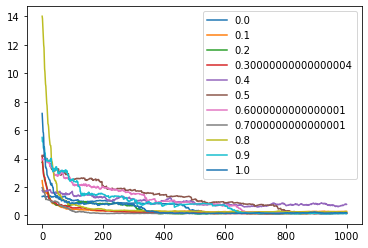

In [37]:

max_episodes = 1000
print_every = 100
running_rewards = []
ms_errors = []
ms_episode_errors = []
env = simple21env()
e = 0.05
step = 0.01

lamdas = np.arange(0.0,1.1,0.1)
fig, ax = plt.subplots()

for lamda in lamdas:
    
    ms_episode_errors = []
    theta = np.random.randn(3*6*2, 1)

    for episode in range(max_episodes):
        E = np.zeros_like(theta)
        running_rewards.append(run_episode(env,E,theta))
        ms_episode_errors.append((np.square(Q_table().reshape((100,2)) - MCq)).mean(axis=None))

        #if episode % print_every == 0 :
        #    print("Running average reward: "+str(np.mean(running_rewards[-print_every:])))
    
    ax.plot(ms_episode_errors,label=lamda)
    ax.legend()
        
    ms_errors.append((np.square(Q_table().reshape(100,2) - MCq)).mean(axis=None))
    print("Running average reward: "+str(np.mean(running_rewards[-print_every:])))

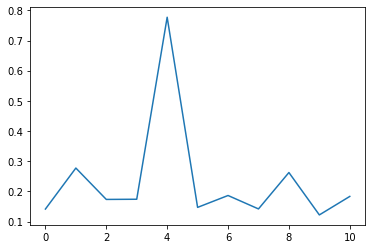

In [38]:
plt.plot(ms_errors)

In [80]:
Q_t = Q_table()

In [81]:
A = np.zeros((10,10))
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        A[i,j] = np.max([Q_t[j,i]])

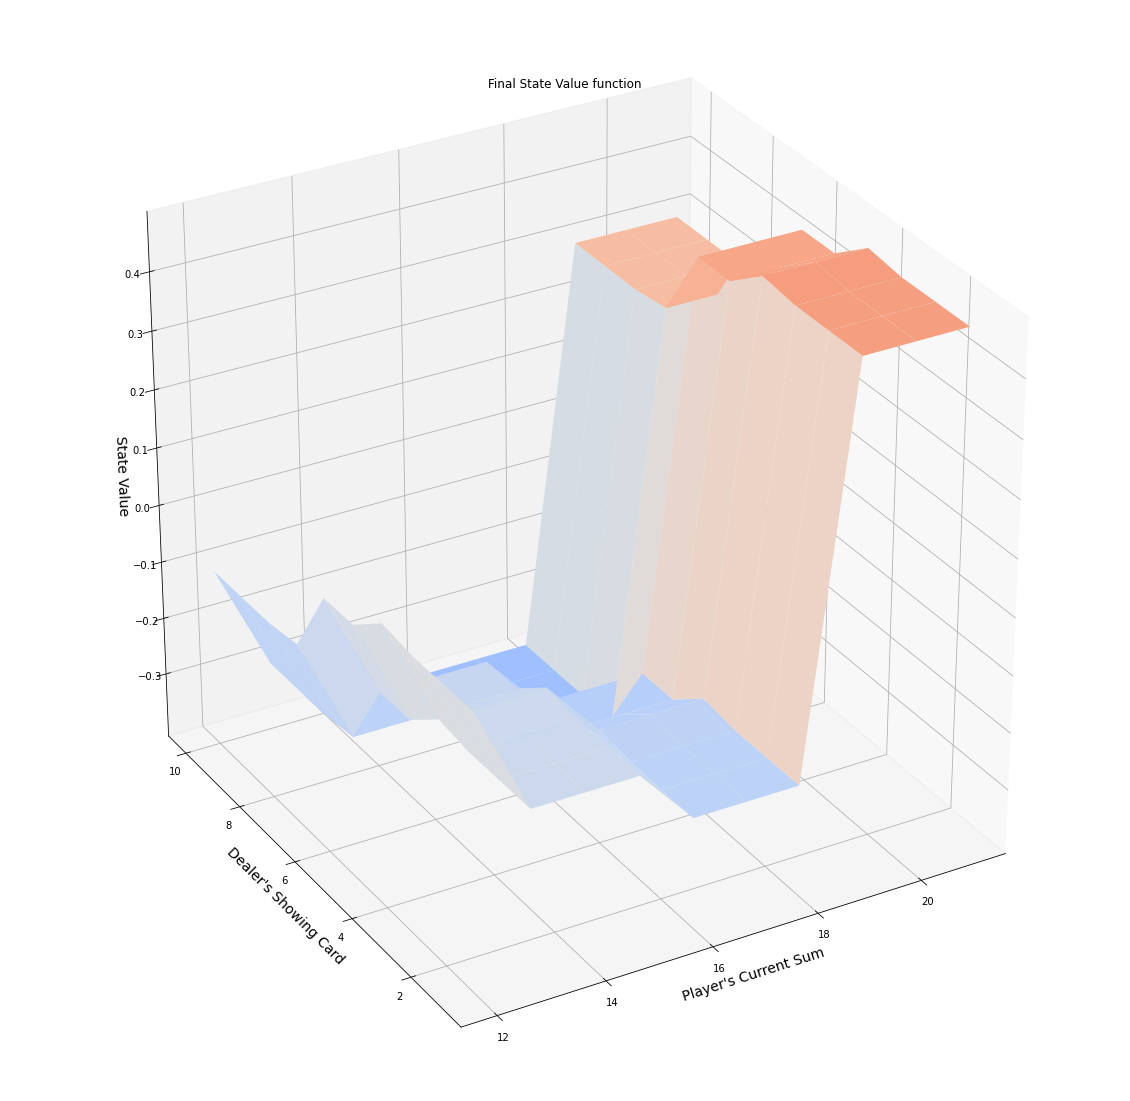

In [82]:
%matplotlib inline

plot_blackjack_values(A.reshape(100,1),5)